## Import libs

In [108]:
import lightgbm as lgb
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score
import joblib
import pandas as pd
import numpy as np

In [109]:
df = pd.read_csv('winequality-red.csv', sep = ';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Data preprocessing

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [111]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


New feature - if quality > 5, then is_high_quality = 1, else = 0. Then let's move on to the binary classification problem

In [112]:
def quality_convert(quality):
    if(quality > 5):
        result = 1
    else:
        result = 0
    return result

In [113]:
df['is_high_quality'] = df['quality'].map(lambda x: quality_convert(x))
df.drop('quality',axis=1, inplace=True)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_high_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [114]:
X = df.drop('is_high_quality', axis = 1)
y = df['is_high_quality']

## Implementation of streaming data reading

Recreating the flow of real data. We split the data into butches and will read them in order.

In [115]:
def streaming_reading(X_train, y_train, batch_size=400):
    X = []
    y = []
    current_line = 0
    train_data, train_label = shuffle(X_train, y_train, random_state=0)
    train_data = train_data.to_numpy()
    for row, target in zip(train_data, train_label):
        X.append(row)
        y.append(target)

        current_line += 1
        if current_line >= batch_size:
            X, y = np.array(X), np.array(y)
            yield X, y
            X, y = [], []
            current_line = 0

## LightGBM 

In [116]:
def IncrementaLightGbm(X, y):  
    gbm = None

    params = {
        'task': 'train',
        'application': 'binary',  
        'boosting_type': 'gbdt', 
        'learning_rate': 0.05,  
        'tree_learner': 'serial',
        'metric': ['binary_logloss', 'auc'], 
        'max_bin': 255,
    }
    streaming_train_iterators = streaming_reading(X, y, batch_size=400)

    for i, data in enumerate(streaming_train_iterators):
        X_batch = data[0]
        y_batch = data[1]
        X_train, X_test, y_train, y_test = train_test_split(X_batch, y_batch, test_size=0.1, random_state=0)
        y_train = y_train.ravel()
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=1000,
                        valid_sets=lgb_eval,
                        init_model=gbm, 
                        early_stopping_rounds=10,
                        verbose_eval=False,
                        keep_training_booster=True)  

        print("{} time".format(i))  
        score_train = dict([(score[1], score[2]) for score in gbm.eval_train()])
        print('The score of the current model in the training set is: logloss=%.4f, auc=%.4f, \n'
              % (score_train['binary_logloss'], score_train['auc']))

    return gbm

## Training

In [117]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2)
gbm = IncrementaLightGbm(train_X, train_y)
pred_y = gbm.predict(test_X)
pred_classes = np.where(pred_y > 0.5, 1, 0)
print(f'F1 score: {f1_score(test_y, pred_classes)}')
print('------------------------------------------')
print(f'Precision: {precision_score(test_y, pred_classes)}')
print('------------------------------------------')
print(f'Recall: {recall_score(test_y, pred_classes)}')

joblib.dump(gbm, 'loan_model.pkl')
gbm = joblib.load('loan_model.pkl')

[LightGBM] [Info] Number of positive: 192, number of negative: 168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 360, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.533333 -> initscore=0.133531
[LightGBM] [Info] Start training from score 0.133531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [159]:
# Metric for Prometheus with Pushgateway
precision = precision_score(test_y, pred_classes)

In [164]:
from prometheus_client import CollectorRegistry, Gauge, push_to_gateway
registry = CollectorRegistry()
g = Gauge('precision_score_from_model', 'precision_score', registry=registry)
g.set(precision)

In [165]:
push_to_gateway('localhost:9091', job='precision_score_job', registry=registry)

My yml-file:

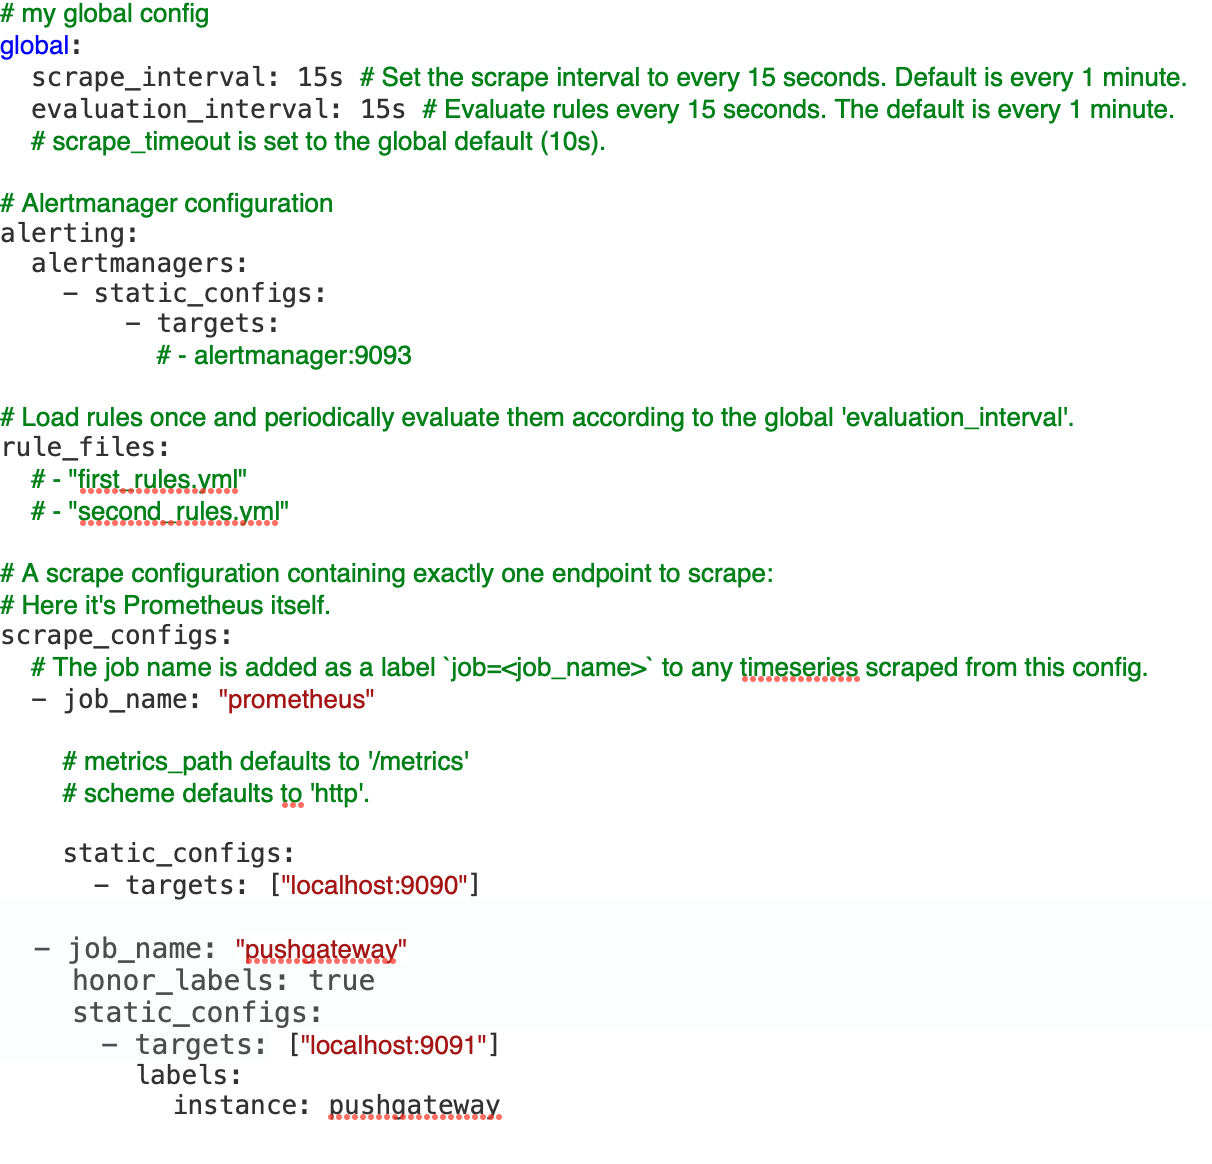

My metric:

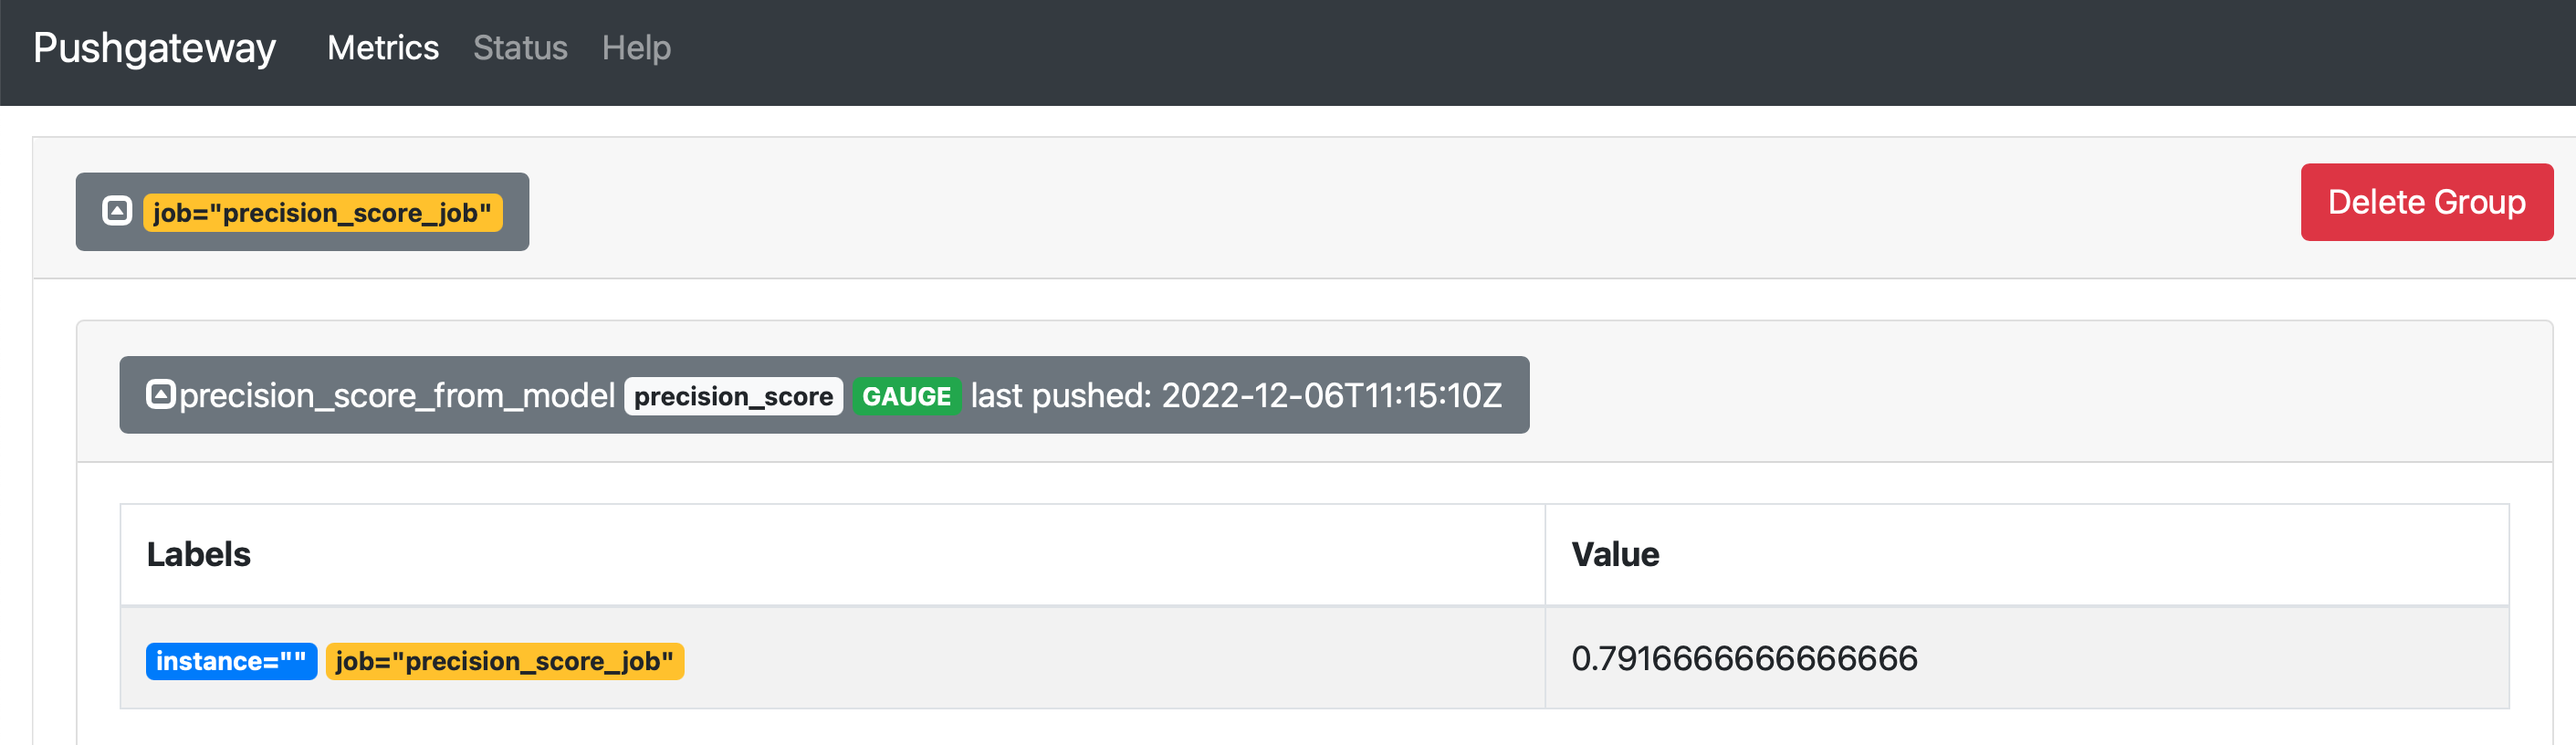